In [1]:
# import required modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from infrasim.component import Component
import pandas as pd
import numpy as np

In [2]:
# load component data
gen_admin_params = pd.read_csv('selected_15_components_data.csv')

component_ids = list(gen_admin_params['component_id'])
dynamics_shapes = list(gen_admin_params['shape'])
dynamics_scales = list(gen_admin_params['scale'])
inspection_costs = list(gen_admin_params['inspection_cost'])
replacement_costs = list(gen_admin_params['replacement_cost'])

In [3]:
def run_simulations(component, budget, num_trials, inspect_interval, replace_failure_threshold, visualize=False):

    # run a policy on the component with baseline strategy
    inspect_interval = inspect_interval
    replace_failure_threshold = replace_failure_threshold
    survive_probs = []

    for trial in range(num_trials):
        budget_remaining = budget
        component.reset()
        num_steps = 0
        estimated_state = 100
        num_survive_steps = 0

        while budget_remaining > 0 and num_steps < 100:

            if component.current_state > 0:
                num_survive_steps += 1

            # actions for baseline
            if num_steps % inspect_interval == 0:
                component.update(action=1)
                budget_remaining -= component.inspect_cost
                last_known_state = component.current_state
            elif component.get_failure_probability(last_known_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
                component.update(action=2)
                budget_remaining -= component.replace_cost
                last_known_state = component.current_state
            else:
                component.update(action=0)
            num_steps += 1
        
        if visualize == True:
            component.visualize_history()
            print(f"Remaining budget: {budget_remaining}")
        survive_probs.append(num_survive_steps/100.0)

    return np.mean(survive_probs), np.std(survive_probs)

In [4]:
# run simulations with components

survival_means = np.zeros((len(component_ids),51))
survival_stds = np.zeros((len(component_ids),51))
budgets = np.arange(0,1001,20)
inspect_interval = 3
num_trials = 5
replace_failure_threshold = 0.5

for i in range(len(component_ids)):

    component =  Component(name=f'{component_ids[i]}', inspect_cost=inspection_costs[i], replace_cost=replacement_costs[i], dynamics_scale=dynamics_scales[i], dynamics_shape=dynamics_shapes[i])

    # load dynamics npy file
    trans_prob_maintain = np.load(f'./dynamics/dynamics_{component_ids[i]}.npy')
    component.trans_prob[:,0,:] = trans_prob_maintain[:,0,:]
    component.trans_prob[:,1,:] = trans_prob_maintain[:,0,:]
    
    for j in range(len(budgets)):
        
        probs_mean, probs_std =  run_simulations(component, budgets[j], num_trials=num_trials, inspect_interval=inspect_interval, replace_failure_threshold=replace_failure_threshold)
        survival_means[i,j] = probs_mean
        survival_stds[i,j] = probs_std


In [5]:
np.save('./results/baseline_survival_means.npy', survival_means)
np.save('./results/baseline_survival_stds.npy', survival_stds)

Replaced due to failure probability 1.0
Replaced due to failure probability 1.0
Replaced due to failure probability 1.0
Replaced due to failure probability 1.0
Replaced due to failure probability 1.0
Replaced due to failure probability 1.0
Replaced due to failure probability 1.0
100
66


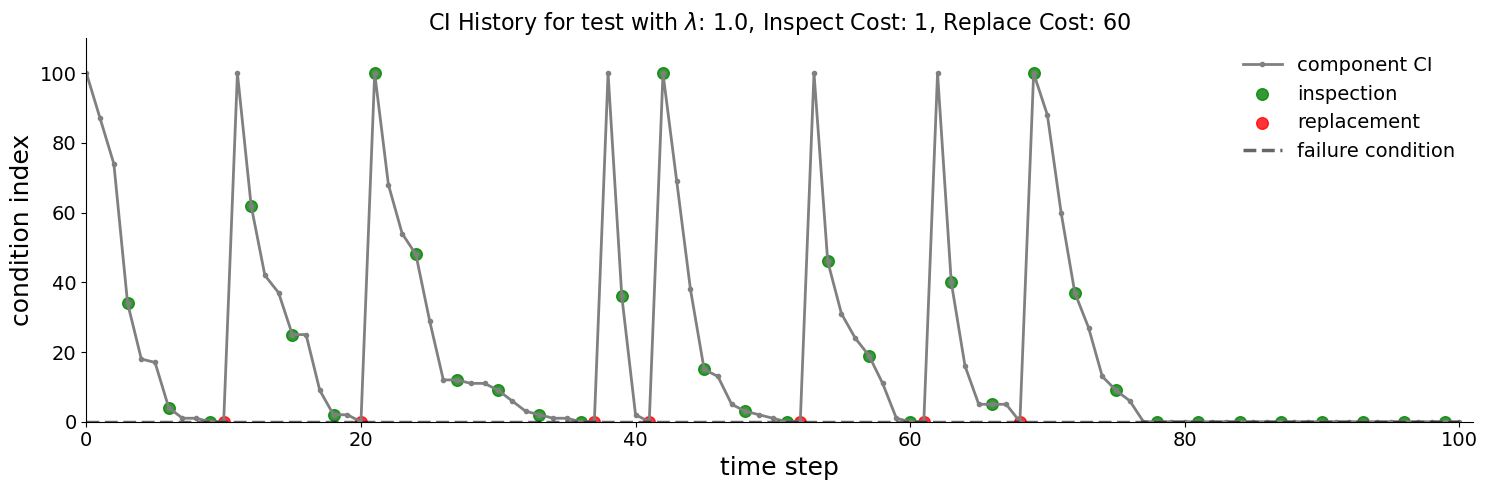

In [20]:
# testing for a single component and budget

# run a policy on the component with baseline strategy
inspect_interval = 3
replace_failure_threshold = 0.8
survive_probs = []

budget_remaining = 500.0
num_steps = 0
estimated_state = 100
num_survive_steps = 0

i = 14
component =  Component(name='test', inspect_cost=1, replace_cost=60, dynamics_scale=36.6, dynamics_shape=1.68)
trans_prob_maintain = np.load(f'./dynamics/dynamics_{component_ids[i]}.npy')
component.trans_prob[:,0,:] = trans_prob_maintain[:,0,:]
component.trans_prob[:,1,:] = trans_prob_maintain[:,0,:]
component.reset()

while budget_remaining > 0 and num_steps < 100:

    if component.current_state > 0:
        num_survive_steps += 1

    # inspection step
    if num_steps % inspect_interval == 0:
        component.update(action=1)
        budget_remaining -= component.inspect_cost
        estimated_state = component.current_state
    else:
        # update estimated state to next state with highest probability
        estimated_state = np.argmax(component.trans_prob[component.current_state,0,:])  
        # replacement
        if component.get_failure_probability(estimated_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
            component.update(action=2)
            print(f'Replaced due to failure probability {component.get_failure_probability(estimated_state)}')
            budget_remaining -= component.replace_cost
            estimated_state = component.current_state
        else:
            component.update(action=0)

    num_steps += 1

print(num_steps)
print(num_survive_steps)
component.visualize_history()